In [37]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

**VGG16 Model**


---

---

---

















In [38]:
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
 
# extract features from each photo in the directory
def extract_features(directory):
    model = VGG16()       # load the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)    # re-structure the model
    print(model.summary())     # summarize
    features = dict()        # extract features from each photo (store array of features)
    for name in listdir(directory):
        filename = directory + '/' + name      # load an image from file
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)            # convert the image pixels to a numpy array
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))       # reshape data for the model
        image = preprocess_input(image)         # prepare the image for the VGG model (convert from RGB TO BGR format, as expected by VGG model)
        feature = model.predict(image, verbose=0)             # get features
        image_id = name.split('.')[0]            # get image id
        features[image_id] = feature           # store feature
        print('>%s' % name)
    return features
 
# extract features from all images
#Enter the directory path containing images
directory = '/Users/karanbadlani/Downloads/Images'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features1.pkl', 'wb'))

Model: "model_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_101 (InputLayer)      [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

**DESCRIPTIONS PROCESSING**

---

---

---







In [39]:
import string

# load doc into memory
def load_doc(filename):
	file = open(filename, 'r')     # open the file as read only
	text = file.read()             # read all text
	file.close()                   # close the file
	return text

# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):        # process lines
		tokens = line.split()             # split line by white space
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]        # take the first token as the image id, the rest as the description
		image_id = image_id.split('.')[0]                   # remove filename from image id
		image_desc = ' '.join(image_desc)                   # convert description tokens back to string
		if image_id not in mapping:                         # create the list if needed
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)                # store description
	return mapping

def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)     # prepare translation table for removing punctuation
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()                               # tokenize
			desc = [word.lower() for word in desc]            # convert to lower case
			desc = [w.translate(table) for w in desc]         # remove punctuation from each token
			desc = [word for word in desc if len(word)>1]     # remove hanging 's' and 'a'
			desc = [word for word in desc if word.isalpha()]  # remove tokens with numbers in them
			desc_list[i] =  ' '.join(desc)                    # store as string

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	all_desc = set()                              # build a list of all description strings
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

#Enter the the commentary text file with path    
filename = '/Users/karanbadlani/Desktop/NEU-DS/NLP/Automated-Cricket-Commentary--main/N_token_Ind_vs_Aus.txt'
doc = load_doc(filename)                          # load descriptions
descriptions = load_descriptions(doc)             # parse descriptions
print('Loaded: %d ' % len(descriptions))
clean_descriptions(descriptions)                  # clean descriptions
vocabulary = to_vocabulary(descriptions)          # summarize vocabulary
print('Vocabulary Size: %d' % len(vocabulary))
save_descriptions(descriptions, 'descriptions1.txt')    # save to file

Loaded: 4168 
Vocabulary Size: 440


**MAPPING PHOTO TO FEATURES FOR TRAIN DATA**

---

---

---







In [40]:
from pickle import load

# load doc into memory
def load_doc(filename):
	file = open(filename, 'r')     # open the file as read only
	text = file.read()             # read all text
	file.close()                   # close the file
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	for line in doc.split('\n'):         # process line by line
		if len(line) < 1:                  # skip empty lines
			continue
		identifier = line.split('.')[0]    # get the image identifier
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	doc = load_doc(filename)                       	# load document
	descriptions = dict()
	for line in doc.split('\n'):             
		tokens = line.split()                         # split line by white space
		image_id, image_desc = tokens[0], tokens[1:]  # split id from description
		if image_id in dataset:                       # skip images not in the set
			if image_id not in descriptions:            # create list
				descriptions[image_id] = list()
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'   # wrap description in tokens
			descriptions[image_id].append(desc)                     # store
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
	all_features = load(open(filename, 'rb'))             # load all features
	features = {k: all_features[k] for k in dataset}      # filter features
	return features

# load training dataset 
filename = '/Users/karanbadlani/Desktop/NEU-DS/NLP/Automated-Cricket-Commentary--main/Ntrain.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_clean_descriptions('descriptions1.txt', train)     # descriptions
print('Descriptions: train=%d' % len(train_descriptions))
train_features = load_photo_features('features1.pkl', train)                  # photo features
print('Photos: train=%d' % len(train_features))

Dataset: 2500
Descriptions: train=2500
Photos: train=2500


**CAPTIONING MODEL**

---

---

---







In [51]:
pip install --upgrade pydot

Note: you may need to restart the kernel to use updated packages.


In [52]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint

# load doc into memory
def load_doc(filename):
	file = open(filename, 'r')      # open the file as read only
	text = file.read()              # read all text
	file.close()                    # close the file
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	for line in doc.split('\n'):        # process line by line
		if len(line) < 1:                 # skip empty lines
			continue
		identifier = line.split('.')[0]   # get the image identifier
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	doc = load_doc(filename)                                      # load document
	descriptions = dict()
	for line in doc.split('\n'):
		tokens = line.split()                                       # split line by white space
		image_id, image_desc = tokens[0], tokens[1:]                # split id from description
		if image_id in dataset:                                     # skip images not in the set
			if image_id not in descriptions:                          # create list
				descriptions[image_id] = list()
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'     # wrap description in tokens
			descriptions[image_id].append(desc)                       	# store
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
	all_features = load(open(filename, 'rb'))            # load all features
	features = {k: all_features[k] for k in dataset}     # filter features
	return features

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
	X1, X2, y = list(), list(), list()
	for key, desc_list in descriptions.items():            # walk through each image identifier
		for desc in desc_list:                               # walk through each description for the image
			seq = tokenizer.texts_to_sequences([desc])[0]      # encode the sequence
			for i in range(1, len(seq)):                       # split one sequence into multiple X,y pairs
				in_seq, out_seq = seq[:i], seq[i]                # split into input and output pair
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]             # pad input sequence
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]     # encode output sequence
				X1.append(photos[key][0])                                       		# store
				X2.append(in_seq)
				y.append(out_seq)
	return array(X1), array(X2), array(y)

# define the captioning model
def define_model(vocab_size, max_length):
	inputs1 = Input(shape=(4096,))                            # feature extractor model
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	inputs2 = Input(shape=(max_length,))                      # sequence model
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	decoder1 = add([fe2, se3])                                 # decoder model
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)          # tie it together [image, seq] [word]
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	print(model.summary())                                             # summarize model
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

# train dataset

# load training dataset
filename = '/Users/karanbadlani/Desktop/NEU-DS/NLP/Automated-Cricket-Commentary--main/Ntrain.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_clean_descriptions('descriptions1.txt', train)       # descriptions
print('Descriptions: train=%d' % len(train_descriptions))
train_features = load_photo_features('features1.pkl', train)                   # photo features
print('Photos: train=%d' % len(train_features))
tokenizer = create_tokenizer(train_descriptions)                                                                                 # prepare tokenizer
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
max_length = max_length(train_descriptions)                                                                                      # determine the maximum sequence length
print('Description Length: %d' % max_length)
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)               # prepare sequences

# dev dataset

# load test set
filename ='/Users/karanbadlani/Desktop/NEU-DS/NLP/Automated-Cricket-Commentary--main/Ntest.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
test_descriptions = load_clean_descriptions('descriptions1.txt', test)           # descriptions
print('Descriptions: test=%d' % len(test_descriptions))
test_features = load_photo_features('features1.pkl', test)                       # photo features
print('Photos: test=%d' % len(test_features))
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)                      # prepare sequences

# fit model

# define the model
model = define_model(vocab_size, max_length)
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'           # define checkpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))        # fit model

Dataset: 2500
Descriptions: train=2500
Photos: train=2500
Vocabulary Size: 426
Description Length: 25
Dataset: 834
Descriptions: test=834
Photos: test=834
Model: "model_99"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_109 (InputLayer)      [(None, 25)]                 0         []                            
                                                                                                  
 input_108 (InputLayer)      [(None, 4096)]               0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 25, 256)              109056    ['input_109[0][0]']           
                                                                                                  
 dropout_6 (Dropout)         (None,

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [53]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

**MODEL EVALUATION**

---

---

---







In [54]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [55]:
from keras.models import load_model
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# prepare tokenizer on train set
 
# load training dataset (6K)
filename = '/Users/karanbadlani/Desktop/NEU-DS/NLP/Automated-Cricket-Commentary--main/Ntrain.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions1.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
 
# prepare test set
 
# load test set
filename = '/Users/karanbadlani/Desktop/NEU-DS/NLP/Automated-Cricket-Commentary--main/Ntest.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions1.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features1.pkl', test)
print('Photos: test=%d' % len(test_features))
 
# load the model
#Enter the path of saved model with lowest loss value
filename = '/Users/karanbadlani/Desktop/NEU-DS/NLP/Automated-Cricket-Commentary--main/model-ep012-loss0.376-val_loss0.479.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 2500
Descriptions: train=2500
Vocabulary Size: 426
Description Length: 25
Dataset: 834
Descriptions: test=834
Photos: test=834
BLEU-1: 0.885649
BLEU-2: 0.824539
BLEU-3: 0.800808
BLEU-4: 0.744673


In [56]:
from keras.preprocessing.text import Tokenizer
from pickle import dump

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# load training dataset (6K)
filename = '/Users/karanbadlani/Desktop/NEU-DS/NLP/Automated-Cricket-Commentary--main/Ntrain.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions1.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer1.pkl', 'wb'))

Dataset: 2500
Descriptions: train=2500


# For image captioning

startseq wicket keeper endseq


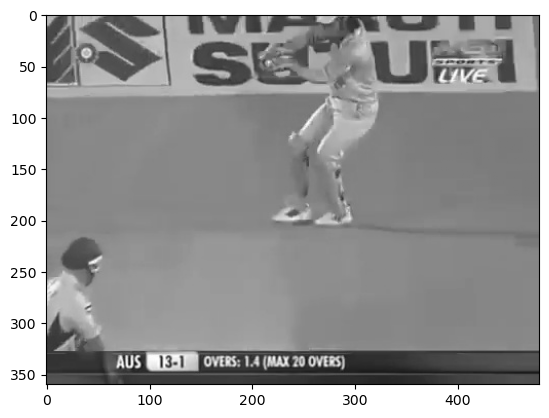

In [57]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
from matplotlib import pyplot as plt

# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# load the tokenizer
tokenizer = load(open('tokenizer1.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 25
# load the model
model = load_model('/Users/karanbadlani/Desktop/NEU-DS/NLP/Automated-Cricket-Commentary--main/model-ep012-loss0.376-val_loss0.479.h5')
# load and prepare the photograph
photo = extract_features('/Users/karanbadlani/Downloads/Images/2_6_15.png')
img = plt.imread(r'/Users/karanbadlani/Downloads/Images/2_6_15.png')
plt.imshow(img)
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

# For multiple image captioning

In [58]:
import pandas as pd
import numpy as np
import os
#To test 
def test(directory):
  tokenizer = load(open('tokenizer1.pkl', 'rb'))
  max_length = 25
  model = load_model('/Users/karanbadlani/Desktop/NEU-DS/NLP/Automated-Cricket-Commentary--main/model-ep012-loss0.376-val_loss0.479.h5')
  lis = []
  list1 = os.listdir(directory)
  for i in list1:
    name = directory + "/" + i
    photo = extract_features(name)
    img = plt.imread(name)
    plt.imshow(img)
    # generate description
    description = generate_desc(model, tokenizer, photo, max_length)
    # Remove startseq and endseq
    description = description.replace('startseq', '').replace('endseq', '')
    print(description)
    lis.append([i,description])
  return lis

#Enter the directory containg images to get captioning
directory = "/Users/karanbadlani/Downloads/Images/Test.mp4" #Test video is of 32sec


 batsman is ready to face the ball 
 bowler is happy for taking that wicket 
 bowler 
 batsman hits the ball 
 two batsmen are on the pitch 
 batsmen are talking 
 two batsmen are on the pitch 
 the ball is hit by batsman 
 the ball go far 
 bowler 
 batsman is going to bat 
 bowler 
 the crowd is enjoying the match 
 fielder is on the field 
 batsman hits the ball 
 bowler is furious for taking that wicket 


KeyboardInterrupt: 

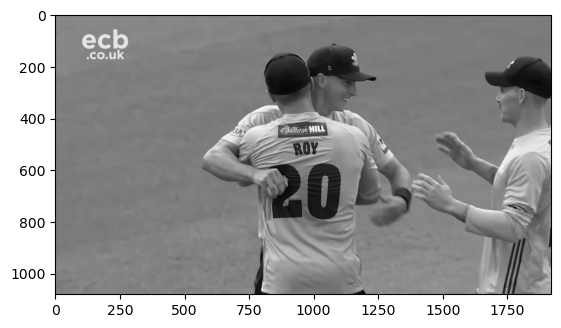

In [ ]:
test(directory)

In [59]:
from collections.abc import Sequence

In [6]:
import asyncio
import threading

def thread_function():
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    try:
        loop.run_until_complete(asyncio.sleep(1))  # Replace with your async function
    finally:
        loop.close()

thread = threading.Thread(target=thread_function)
thread.start()
thread.join()

async def ws(f):
    pass


async def callback(*args):
    pass


async def create():
    tasks = [
        asyncio.create_task(
            ws(callback)
        )
    ]

    await asyncio.wait(tasks)


if __name__ == "__main__":
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

    loop.run_until_complete(create())

RuntimeError: Cannot run the event loop while another loop is running

In [1]:


import streamlit as st
import io
import cv2
import os
from PIL import Image
from gtts import gTTS 
import model_final
import similarity





st.title("Play Uploaded File")

uploaded_file = st.file_uploader("Choose a video...", type=["mp4"])
temporary_location = False

if uploaded_file is not None:
    g = io.BytesIO(uploaded_file.read())  ## BytesIO Object
    temporary_location = "/Users/karanbadlani/Desktop/NEU-DS/NLP/Test.mp4"

    with open(temporary_location, 'wb') as out:  ## Open temporary file as bytes
        out.write(g.read())  ## Read bytes into file

    # close file
    out.close()


@st.cache(allow_output_mutation=True)
def get_cap(location):
    print("Loading in function", str(location))
    video_stream = cv2.VideoCapture(str(location))

    # Check if camera opened successfully
    if (video_stream.isOpened() == False):
        print("Error opening video  file")
    return video_stream


scaling_factorx = 0.900
scaling_factory = 0.9
image_placeholder = st.empty()
currentframe = 1
#Enter a directory for the frames to get stored in
target = '/Users/karanbadlani/Desktop/NEU-DS/NLP/Automated-Cricket-Commentary--main/frames'
dr = similarity.DuplicateRemover(target)
list1 = os.listdir(target)
try:
    for i in list1:
        os.remove(target+"/"+i)
except:
    print("Break")
#img1 = str(1) + '.jpg'


def model1(file_name,path):
    # load the tokenizer
    tokenizer = model_final.load(open('tokenizer1.pkl', 'rb'))
    # pre-define the max sequence length (from training)
    max_length = 25
    # load the model
    #model = load_model('/C:/Users/User/Desktop/All_codes/Stremlit/Model/model-ep009-loss0.391-val_loss0.483.h5')
    model = model_final.load_model(os.path.join(os.getcwd(), 'Model', '/Users/karanbadlani/Desktop/NEU-DS/NLP/Automated-Cricket-Commentary--main/model-ep012-loss0.376-val_loss0.479.h5'))
    # load and prepare the photograph
    photo = model_final.extract_features(path)
    #img = plt.imread('C:/Users/User/Desktop/All_codes/Stremlit/Model/1 - Copy.png')
    #plt.imshow(img)
    # generate description
    text = model_final.generate_desc(model, tokenizer, photo, max_length)
    text = text.split()
    #startseq bowler is bowling endseq
    text.remove('startseq')
    text.remove('endseq')
    text = ' '.join(text)
    st.write(text)
    audio(file_name,text)


def audio(b,name2):
    #Enter a directory for audio created for the comments generated to get stored
    target = "/Users/karanbadlani/Desktop/NEU-DS/NLP/Automated-Cricket-Commentary--main/audio/"
    language = 'en'
    myobj = gTTS(text=name2, lang=language, slow=False) 
    myobj.save(target + b + ".mp3")
    os.system(target + b + ".mp3") 




def grey_scale(path,target):
    #list1 = os.listdir(directory)
    #for i in list1:
    length = len(path.split('/'))
    b = path.split('/')[length-1]
    b = b.split('.')[0]
    #name = path
    #print(name)
    img = Image.open(path).convert('LA')
    name2 = target + "/" + b + ".png"
    img.save(name2)
    #st.write(name2)
    model1(b,name2)
    #audio(b,name2)

image_checkpoint = 1

if temporary_location:
    while True:
        # here it is a CV2 object
        video_stream = get_cap(temporary_location)
        # video_stream = video_stream.read()
        ret, image = video_stream.read()
        if ret:
            if len(os.listdir(target)) < 1:
                print("first loop")
                # if video is still left continue creating images 
                name = target +"/"+ str(currentframe) + '.jpg'
                print ('Creating...' + name) 
                img1 = str(currentframe) + '.jpg'
                name1 = currentframe
                # writing the extracted images 
                cv2.imwrite(name, image) 
                #Enter path for the greyscale image of frames to be stored
                grey_scale(name,'C:/Grey_scale')

                # increasing counter so that it will 
                # show how many frames are created 
                currentframe += 1
                #img2 = str(currentframe) + '.jpg'
                cv2.waitKey(100)
                #img1 = name
            else:
                # if video is still left continue creating images 
                #print(img1)
                #img1 = str(name1) + ".jpg"
                #print("second_loop")
                name = target +"/"+ str(currentframe) + '.jpg'
                print ('Creating...' + name) 
                img2 = str(currentframe) + '.jpg'

                # writing the extracted images 
                cv2.imwrite(name, image) 
          

                # increasing counter so that it will 
                # show how many frames are created 
                currentframe += 1
                #img2 = str(currentframe) + '.jpg'
                if dr.similarity_between(target,img1,img2) == 1:
                    os.remove(target + "/" + img2 )
                    #print("similar")
                    count = 1
                else:
                    #print("next image")
                    img1 = str(currentframe-1) + '.jpg'
                    path1 = target + "/" + img1
                    #print(img1)
                    image_checkpoint +=1 
                    if image_checkpoint < 41:
                        if image_checkpoint%5 == 0:
                        # or image_checkpoint == 1:
                            grey_scale(path1,'C:/Grey_scale')
                    #break
        else:
            print("there was a problem or video was finished")
            cv2.destroyAllWindows()
            video_stream.release()
            break
        # check if frame is None
        if image is None:
            print("there was a problem None")
            # if True break the infinite loop
            break

        image_placeholder.image(image, channels="BGR", use_column_width=True)

        cv2.destroyAllWindows()
    video_stream.release()


    cv2.destroyAllWindows()

NameError: name 'asyncio' is not defined